# Bayesian OOD Training

In [9]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dists
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white')
import tikzplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = 36
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


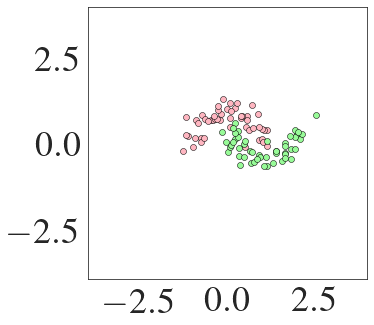

In [334]:
np.random.seed(7777)
size = 100
train_range = (-6, 6)

# X, Y = datasets.make_blobs(n_samples=size, centers=3, cluster_std=1.5, 
#                            center_box=train_range, random_state=7)
X, Y = datasets.make_moons(n_samples=size, noise=0.2, random_state=7)

test_range = (-4, 4)

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='lightpink', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='palegreen', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='violet', edgecolors='k', linewidths=0.5)

plt.xlim(test_range);
plt.ylim(test_range);

In [338]:
def plot(X, Y, X1_test, X2_test, Z, test_range, save_name=None, zo=False):
    cmap = 'Purples'
    plt.figure(figsize=(6, 3))

    im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=np.arange(0, 1.01, 0.1))
#     plt.colorbar(im)
    
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='lightpink', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='palegreen', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='violet', edgecolors='k', linewidths=0.5)

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);
    
    if save_name is not None:
        plt.savefig(f'{save_name}.pdf', bbox_inches='tight')
#         tikzplotlib.save(f'{save_name}.tex')
    
    if zo:
        # draw a new figure and replot the colorbar there
        fig, ax = plt.subplots()
        plt.colorbar(im, ax=ax)
        ax.remove()
        plt.savefig(f'figs/colorbar.pdf', bbox_inches='tight')

    plt.show();

In [339]:
EPS = 1e-30


def train_test(mode='nc', weight_decay=5e-4, n_epochs=5000, damping=1e-3):
    assert mode in ['plain', 'nc', 'sl', 'ml', 'oe']
        
    torch.manual_seed(2)
    np.random.seed(2)

    m, n = X.shape
    h = 100  # num. hidden units per layer
    num_classes = (5 if mode == 'nc' else 4)


    class Model(nn.Module):

        def __init__(self):
            super(Model, self).__init__()

            self.feature_map = nn.Sequential(
                nn.Linear(n, h),
#                 nn.BatchNorm1d(h),
                nn.ReLU(), 
                nn.Linear(h, h), 
#                 nn.BatchNorm1d(h),
                nn.ReLU()
            )

            self.clf = nn.Linear(h, num_classes, bias=False)

        def forward(self, x):
            x = self.feature_map(x)
            return self.clf(x)


    X_train = torch.from_numpy(X).float()
    y_train = torch.from_numpy(Y).long()
    
    X_out = torch.from_numpy(np.random.uniform(*train_range, size=[m, n])).float()
    
    if mode == 'sl':
        def label_smoothing(x_onehot, eps=1e-8):
            N, K = x_onehot.shape
            labels = x_onehot.argmax(-1)
            x_smooth = eps * torch.ones_like(x_onehot)
            x_smooth[range(N), labels] = 1 - (K-1)*eps
            return x_smooth
        
        # Label smoothing is needed since there is the term log(y) in the Dirichlet loglik
        y_train = F.one_hot(y_train, num_classes).float()
        y_train = label_smoothing(y_train, eps=1e-2)
        
        
    # Loss
    def nll(logits_in, logits_out):
        if mode == 'sl':
            prec = 100
            p_in, p_out = torch.softmax(logits_in, -1), torch.softmax(logits_out, -1)
            nll = -dists.Dirichlet(prec*p_in).log_prob(y_train).mean()
            nll += -dists.Dirichlet(prec*p_out).log_prob(y_out).mean()
        else:
            nll = F.cross_entropy(logits_in, y_train, reduction='mean')
            
            if mode == 'nc':
                nll += F.cross_entropy(logits_out, y_out, reduction='mean')
            elif mode == 'ml':
                nll += -dists.Dirichlet(torch.softmax(logits_out, -1)).log_prob(y_out).mean()
            elif mode == 'oe':
                nll += -0.5*torch.log_softmax(logits_out, -1).mean()

        return nll
        

    model = Model()
    opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=weight_decay)

    for it in range(n_epochs):
        if mode == 'nc':
            # Last class, zero-indexed
            y_out = (num_classes-1)*torch.ones(m).long()
        else:
            y_out = 1/num_classes*torch.ones(m, num_classes).float()

        logits_all = model(torch.cat([X_train, X_out], dim=0)).squeeze()
        logits_in, logits_out = logits_all[:m], logits_all[m:]
        
        loss = nll(logits_in, logits_out)

        loss.backward()
        opt.step()
        opt.zero_grad()

    print(f'Loss: {loss.item():.3f}')
    
    
    ''' ============================================================================= '''
    
    
    import torch.autograd as autograd
    from backpack.hessianfree.ggnvp import ggn_vector_product
    from backpack.utils.convert_parameters import vector_to_parameter_list

    model.zero_grad()
    
    W = list(model.parameters())[-1]
    shape_W = W.shape


    def get_covariance(var0, damping=1e-3):
        ''' Damping is to avoid numerical issue '''
        last_layer = nn.Sequential(list(model.modules())[-1])
        num_params = sum(p.numel() for p in last_layer.parameters())
        ggn = torch.zeros(num_params, num_params)
        
        logits_all = model(torch.cat([X_train, X_out], dim=0)).squeeze()
        logits_in, logits_out = logits_all[:m], logits_all[m:]
        
        loss = nll(logits_in, logits_out)        

        for i in range(num_params):
            v = torch.zeros(num_params)
            v[i] = 1.
            v = vector_to_parameter_list(v, last_layer.parameters())
            ggn_i = torch.cat([
                a.flatten() for a in ggn_vector_product(loss, logits_all, last_layer, v)
            ])
            ggn[i, :] = ggn_i

        ggn += damping*torch.eye(ggn.shape[0])
        Sigma = torch.inverse(len(logits_all)*ggn + 1/var0*torch.eye(ggn.shape[0])).detach()

        return Sigma


    @torch.no_grad()
    def predict(x, Sigma):    
        phi = model.feature_map(x)  # Feature vector of x
        
        posterior = dists.MultivariateNormal(W.flatten(), Sigma)
        n_samples = 1000
                
        py = 0
        for _ in range(n_samples):
            W_sample = posterior.sample().reshape(shape_W)
            py += 1/n_samples * torch.softmax(phi @ W_sample.T, -1)
            
        return py.numpy()


    n_data = 2*m  # Since we have an additional m OOD data
    var0 = 1/(2*weight_decay*n_data)

    # Get the posterior covariance and make prediction
    Sigma = get_covariance(var0, damping)
    
    
    ''' ============================================================================= '''
    
    
    model.eval()
    
    
    for zoomed_out in [False, True]:
        # Test data
        size = 50

        if not zoomed_out:
            test_range = (-4, 4); 
            save_name = f'figs/toy_{mode}'; 
            save_name_la = f'figs/toy_{mode}_la'
        else:
            test_range = (-100, 100); 
            save_name = f'figs/toy_{mode}_zoomedout'; 
            save_name_la = f'figs/toy_{mode}_zoomedout_la'

        print(test_range)

        test_rng = np.linspace(*test_range, size)

        X1_test, X2_test = np.meshgrid(test_rng, test_rng)
        X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T
        X_test = torch.from_numpy(X_test).float()

        # MAP
        with torch.no_grad():
            py = torch.softmax(model(X_test), -1).numpy()
            
            if mode == 'nc':
                py = py[:, :-1]
#                 py /= py.sum(-1, keepdims=True) + 1e-8
            
            conf = py.max(-1).reshape(size, size)
            plot(X, Y, X1_test, X2_test, conf, test_range, save_name=save_name, zo=zoomed_out)

        # Laplace
        py = predict(X_test, Sigma)
        
        if mode == 'nc':
            py = py[:, :-1]
#             py /= py.sum(-1, keepdims=True)
            
        conf = py.max(-1).reshape(size, size)
        plot(X, Y, X1_test, X2_test, conf, test_range, save_name=save_name_la, zo=zoomed_out)

Loss: 0.351
(-4, 4)


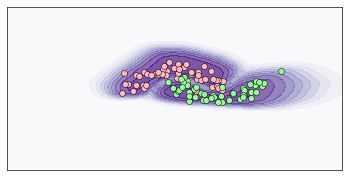

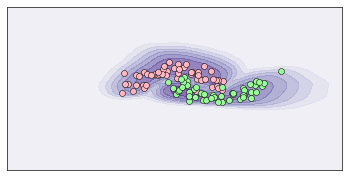

(-100, 100)


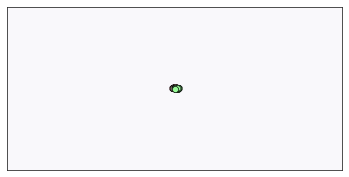

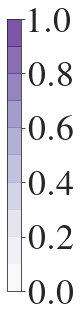

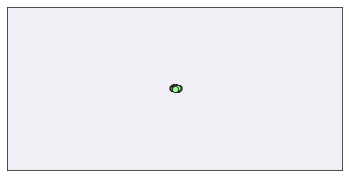

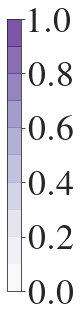

Loss: -17.752
(-4, 4)


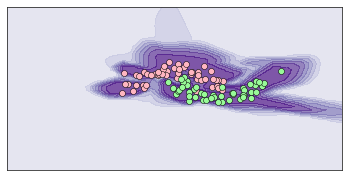

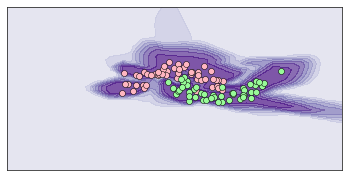

(-100, 100)


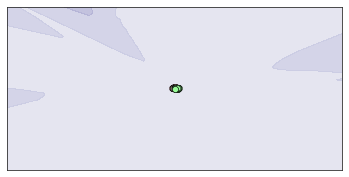

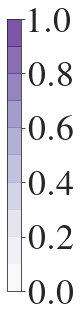

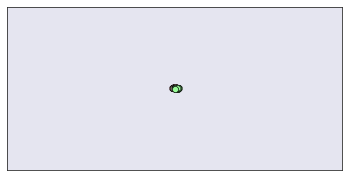

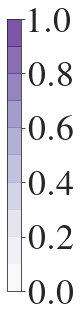

Loss: 1.402
(-4, 4)


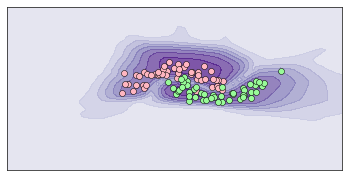

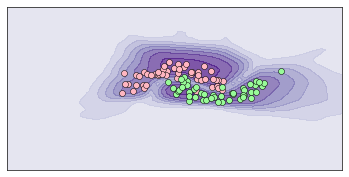

(-100, 100)


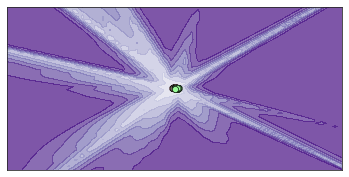

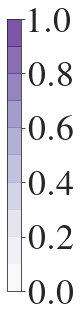

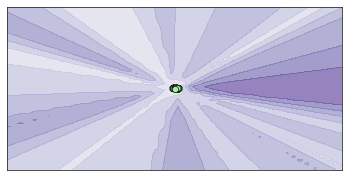

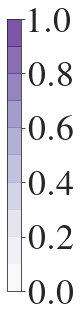

Loss: 0.912
(-4, 4)


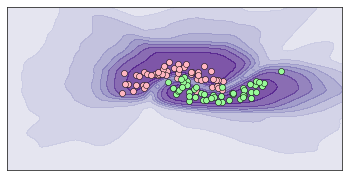

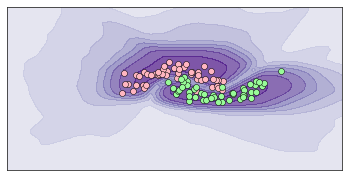

(-100, 100)


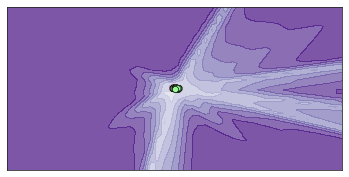

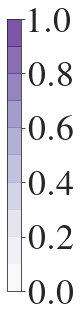

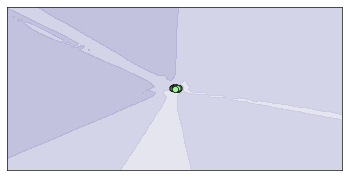

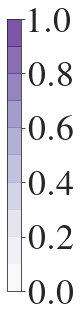

In [340]:
train_test('nc', weight_decay=1e-4, n_epochs=5000, damping=1e-3)
train_test('sl', weight_decay=1e-4, n_epochs=5000, damping=1e-2)
train_test('ml', weight_decay=1e-4, n_epochs=5000, damping=1e-2)
train_test('oe', weight_decay=1e-4, n_epochs=5000, damping=1e-3)